# LLM Translation Metrics Aggregation

This notebook aggregates translation metrics (BLEU, chrF, TER, BERT) from LLM experiments and generates comparison visualizations.

In [1]:
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Configuration
CLEANED_DATA_DIR = Path('cleaned_data')
OUTPUT_DIR = Path('aggregated_metrics')
CHARTS_DIR = OUTPUT_DIR / 'comparison_charts'

# Metrics to aggregate
METRICS = ['bleu_score', 'chrF_score', 'ter_test', 'bert_score_f1']

# Create output directories
OUTPUT_DIR.mkdir(exist_ok=True)
CHARTS_DIR.mkdir(exist_ok=True)

## 1. Load and Aggregate Data

In [3]:
def load_json_file(filepath):
    """Load a JSON file and return its contents."""
    with open(filepath, 'r') as f:
        return json.load(f)

def compute_averages(data):
    """Compute average metrics from a list of prompt results."""
    if not data:
        return None
    
    averages = {}
    for metric in METRICS:
        values = [item.get(metric, 0) for item in data if metric in item]
        if values:
            averages[f'avg_{metric}'] = sum(values) / len(values)
        else:
            averages[f'avg_{metric}'] = 0
    
    averages['sample_count'] = len(data)
    return averages

def get_round_number(filename):
    """Extract round number from filename (e.g., '1.json' -> 1)."""
    return int(Path(filename).stem)

In [4]:
def process_all_data():
    """Process all LLM data and return aggregated results."""
    all_results = []
    
    # Get all LLM folders
    llm_folders = [d for d in CLEANED_DATA_DIR.iterdir() if d.is_dir()]
    
    for llm_folder in sorted(llm_folders):
        llm_name = llm_folder.name
        print(f"Processing {llm_name}...")
        
        # Walk through all JSON files
        for json_file in llm_folder.rglob('*.json'):
            # Get relative path for category info
            rel_path = json_file.relative_to(llm_folder)
            category = str(rel_path.parent)
            round_num = get_round_number(json_file.name)
            
            # Load and compute averages
            data = load_json_file(json_file)
            averages = compute_averages(data)
            
            if averages:
                result = {
                    'llm': llm_name,
                    'category': category,
                    'round': round_num,
                    **averages
                }
                all_results.append(result)
                
                # Save individual JSON file
                output_path = OUTPUT_DIR / llm_name / category
                output_path.mkdir(parents=True, exist_ok=True)
                
                output_file = output_path / f'round_{round_num}_avg.json'
                with open(output_file, 'w') as f:
                    json.dump(result, f, indent=2)
    
    return all_results

# Process all data
all_results = process_all_data()
print(f"\nTotal aggregated results: {len(all_results)}")

Processing llama3_1b...
Processing llama3_8b...
Processing mistral...
Processing phi3_14b...
Processing phi3_8b...
Processing qwen_14b...

Total aggregated results: 102


## 2. Create Summary DataFrame

In [5]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_results)
df.head(10)

,llm,category,round,avg_bleu_score,avg_chrF_score,avg_ter_test,avg_bert_score_f1,sample_count
0,llama3_1b,zero_shot,1,3.943224,5.875656,90.000000,0.857238,5
1,llama3_1b,gramatical_induction,4,7.161557,5.995013,92.323232,0.841428,5
2,llama3_1b,gramatical_induction,2,10.216873,11.561883,75.555556,0.861584,5
3,llama3_1b,gramatical_induction,1,8.170809,6.357673,130.476190,0.841470,5
4,llama3_1b,gramatical_induction,3,1.989490,5.741136,137.333333,0.826213,5
5,llama3_1b,gramatical_induction,5,3.239141,7.735291,94.185464,0.824876,5
6,llama3_1b,morphological_induction,1,6.186577,21.908226,102.128169,0.000000,15
7,llama3_1b,few_shot/translation_question,4,1.353353,8.722629,96.666667,0.795912,5
8,llama3_1b,few_shot/translation_question,2,0.000000,6.834040,97.142857,0.795093,5
9,llama3_1b,few_shot/translation_question,1,1.104480,9.541957,115.000000,0.786253,5


In [6]:
# Aggregate by LLM and round (across all categories)
summary_df = df.groupby(['llm', 'round']).agg({
    'avg_bleu_score': 'mean',
    'avg_chrF_score': 'mean',
    'avg_ter_test': 'mean',
    'avg_bert_score_f1': 'mean',
    'sample_count': 'sum'
}).reset_index()

summary_df

,llm,round,avg_bleu_score,avg_chrF_score,avg_ter_test,avg_bert_score_f1,sample_count
0,llama3_1b,1,4.101914,11.750307,117.520872,0.672146,40
1,llama3_1b,2,6.298556,10.021911,109.455026,0.840473,20
2,llama3_1b,3,2.112818,10.886596,139.111111,0.812310,20
3,llama3_1b,4,2.838303,9.989555,116.329966,0.832744,20
4,llama3_1b,5,7.305978,15.159625,162.839599,0.845143,20
5,llama3_8b,1,21.420665,35.312603,125.645321,0.714197,40
6,llama3_8b,2,15.423945,37.992346,105.867725,0.898505,20
7,llama3_8b,3,11.091338,40.729922,147.656085,0.890067,20
8,llama3_8b,4,17.837337,34.844065,85.681818,0.888812,20
9,llama3_8b,5,24.969486,45.693910,90.276974,0.910693,20


In [7]:
# Save summary to CSV
summary_csv_path = CHARTS_DIR / 'all_models_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"Saved summary to {summary_csv_path}")

Saved summary to aggregated_metrics/comparison_charts/all_models_summary.csv


## 3. Generate Comparison Charts

In [8]:
def create_round_comparison_chart(df, round_num):
    """Create a grouped bar chart comparing LLMs for a specific round."""
    round_data = df[df['round'] == round_num]
    
    if round_data.empty:
        print(f"No data for round {round_num}")
        return
    
    llms = round_data['llm'].tolist()
    x = np.arange(len(llms))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot bars for each metric (excluding TER for better visualization, or normalize)
    metrics_to_plot = [
        ('avg_bleu_score', 'BLEU', '#FF6B6B'),
        ('avg_chrF_score', 'chrF', '#4ECDC4'),
        ('avg_bert_score_f1', 'BERT F1', '#45B7D1'),
    ]
    
    for i, (col, label, color) in enumerate(metrics_to_plot):
        values = round_data[col].tolist()
        offset = (i - len(metrics_to_plot)/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=label, color=color, alpha=0.8)
    
    ax.set_xlabel('LLM Model', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Round {round_num} - LLM Comparison (BLEU, chrF, BERT)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(llms, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save chart
    chart_path = CHARTS_DIR / f'round_{round_num}_comparison.png'
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved chart to {chart_path}")

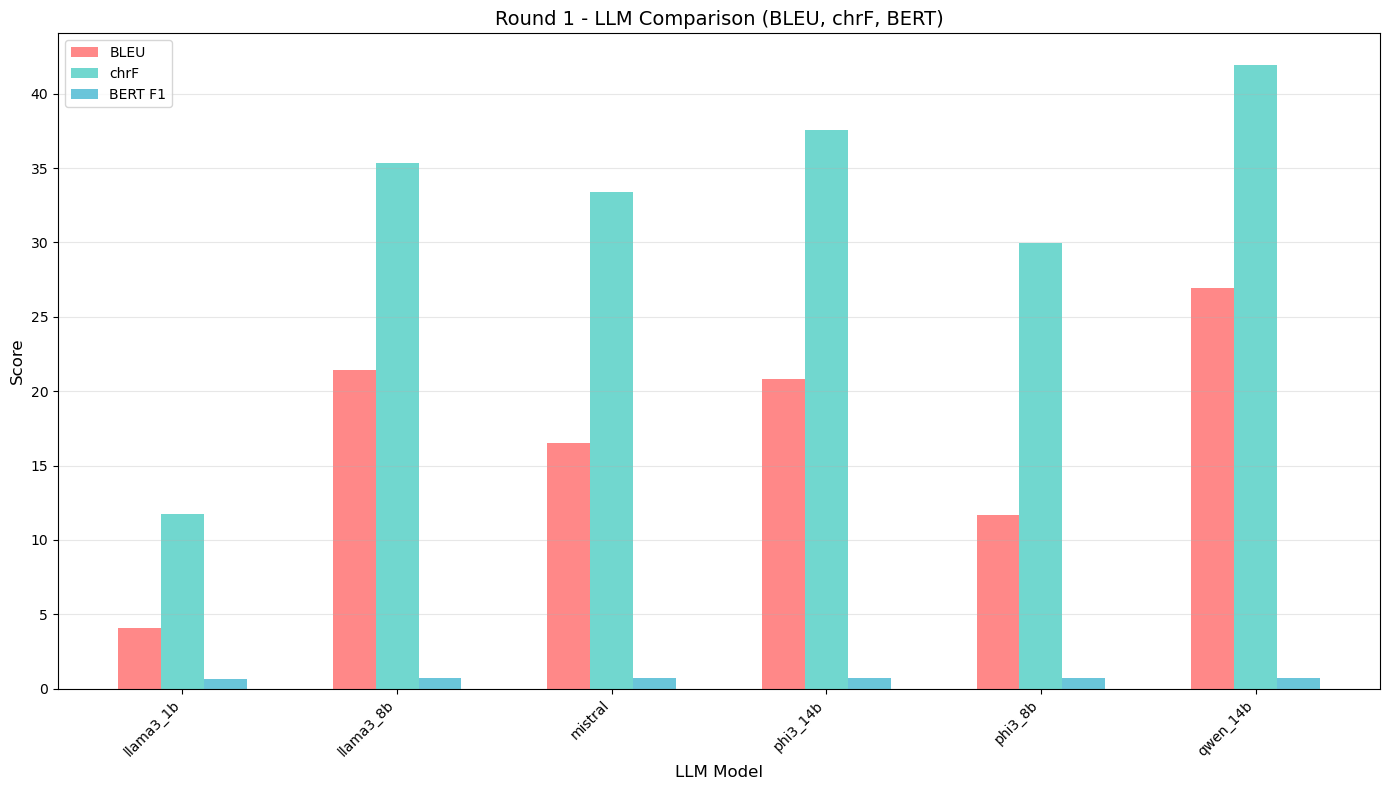

Saved chart to aggregated_metrics/comparison_charts/round_1_comparison.png


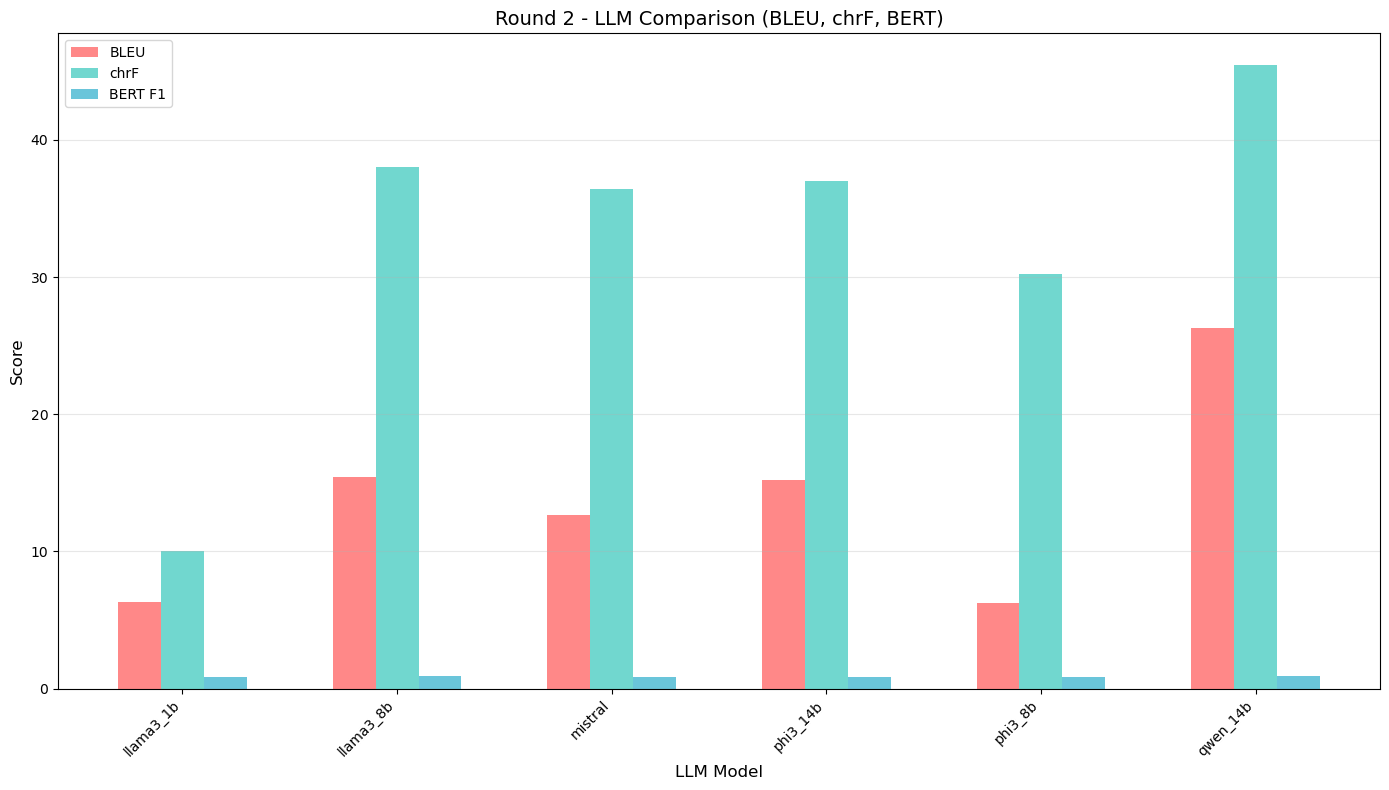

Saved chart to aggregated_metrics/comparison_charts/round_2_comparison.png


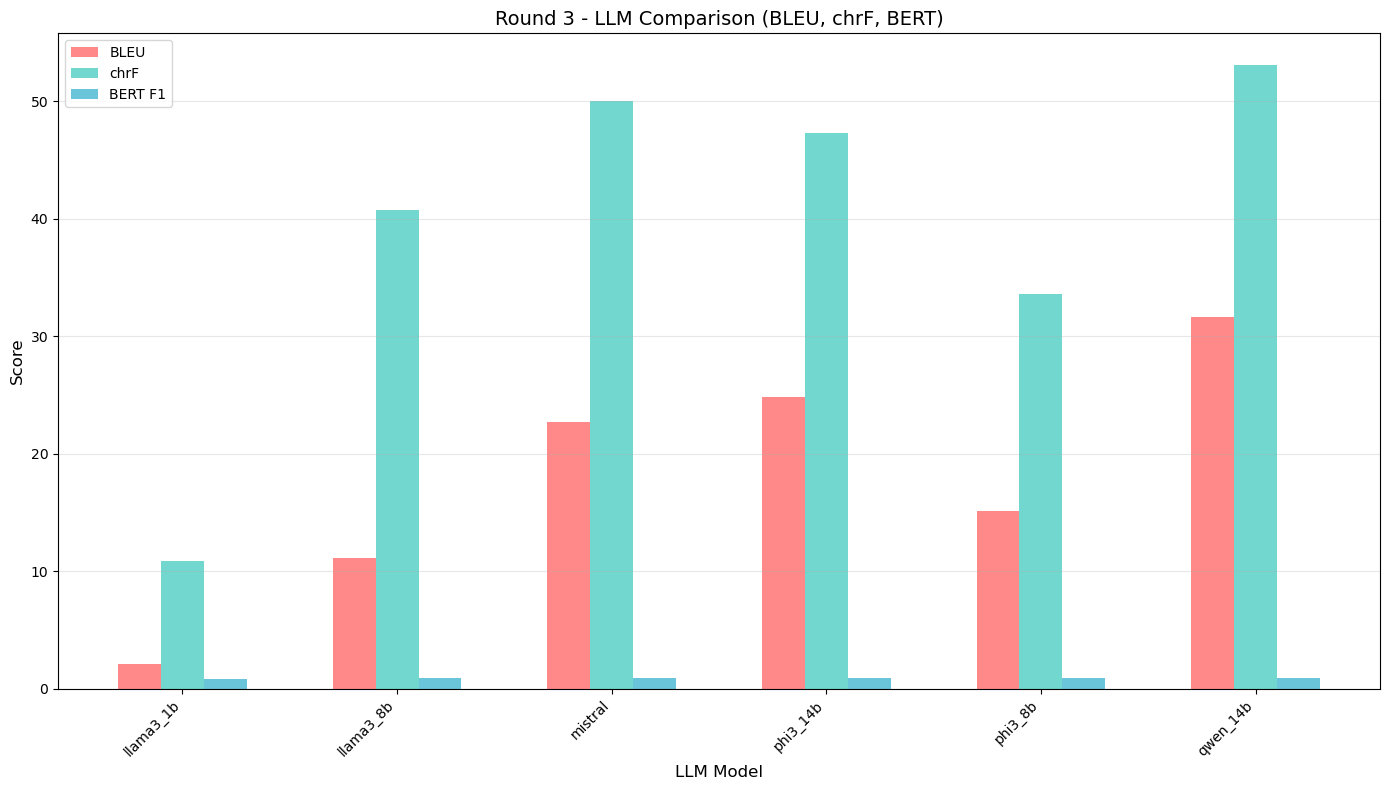

Saved chart to aggregated_metrics/comparison_charts/round_3_comparison.png


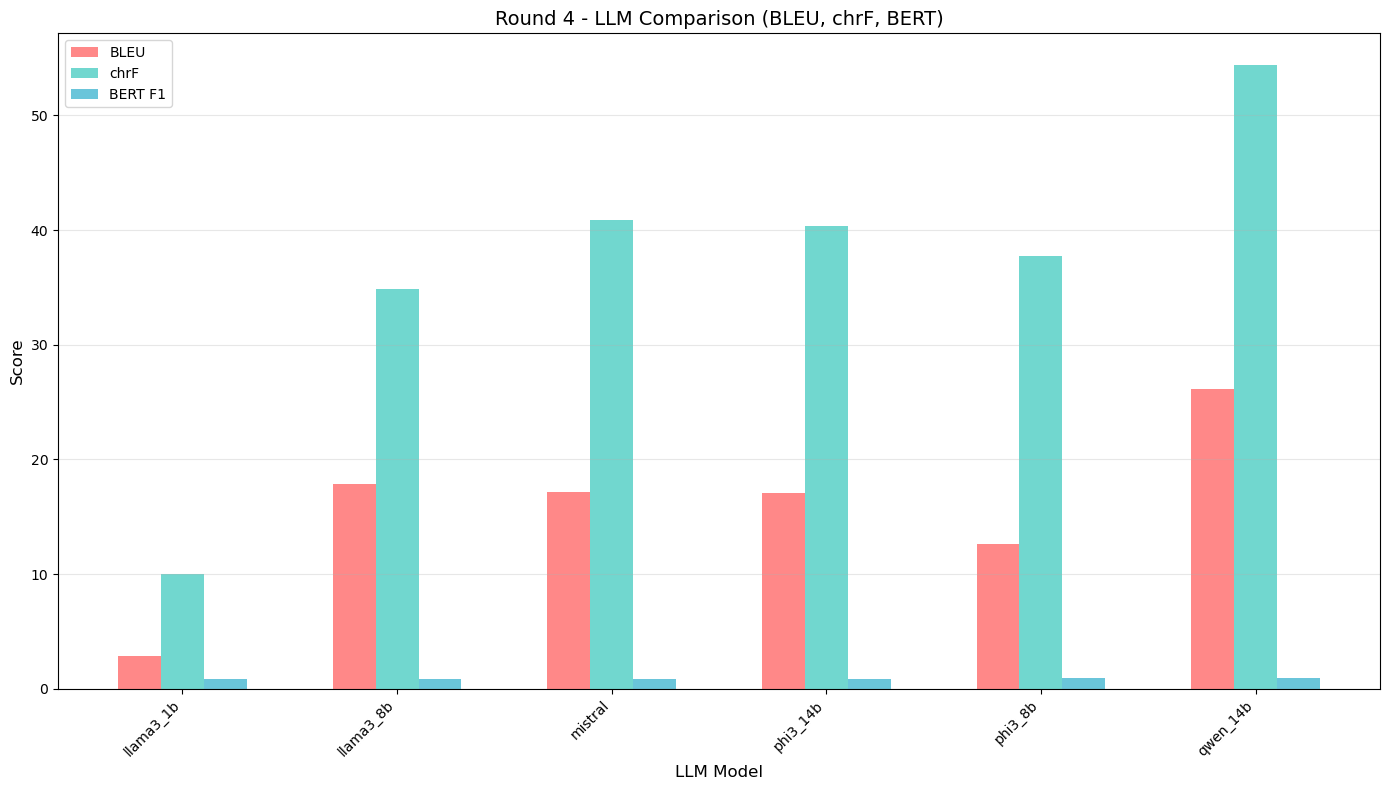

Saved chart to aggregated_metrics/comparison_charts/round_4_comparison.png


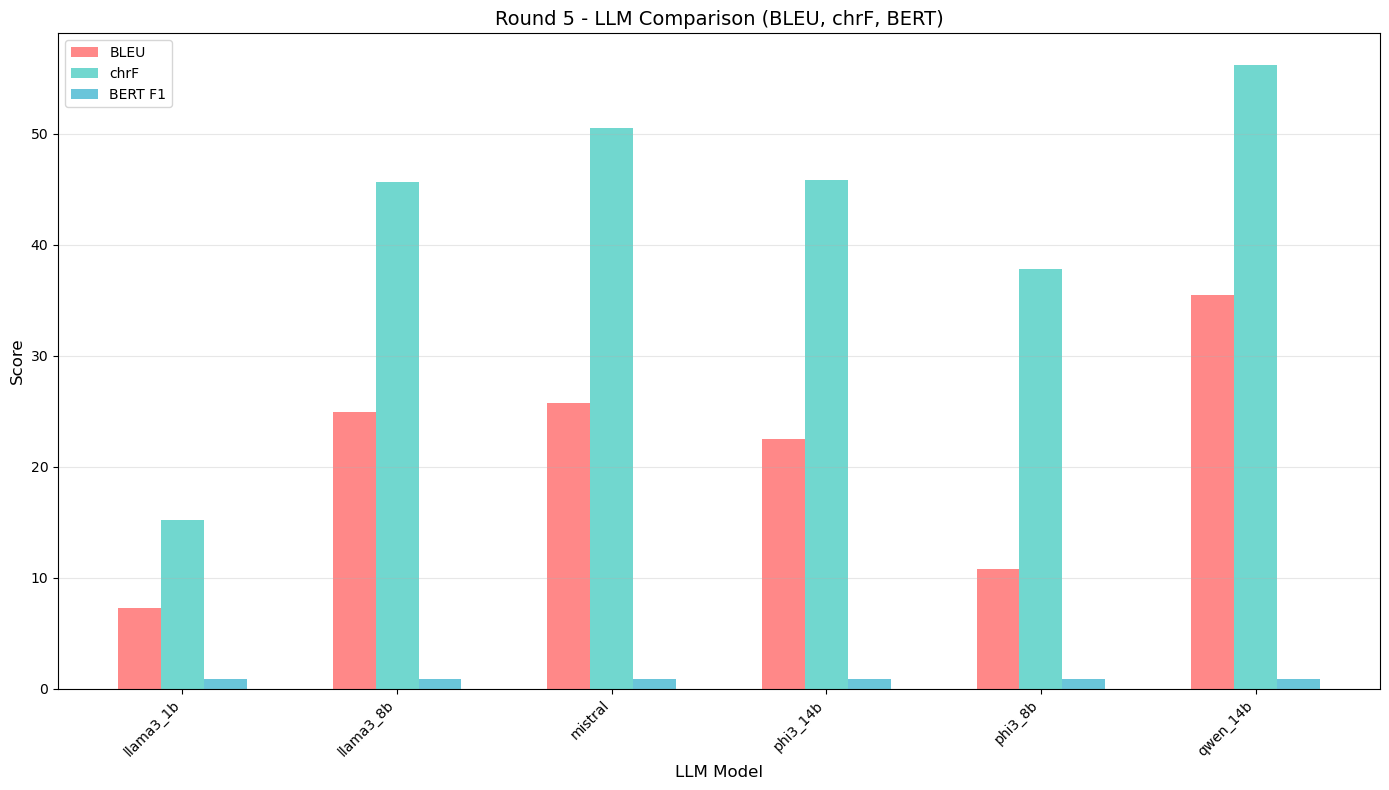

Saved chart to aggregated_metrics/comparison_charts/round_5_comparison.png


In [9]:
# Generate charts for each round
rounds = sorted(summary_df['round'].unique())
for round_num in rounds:
    create_round_comparison_chart(summary_df, round_num)

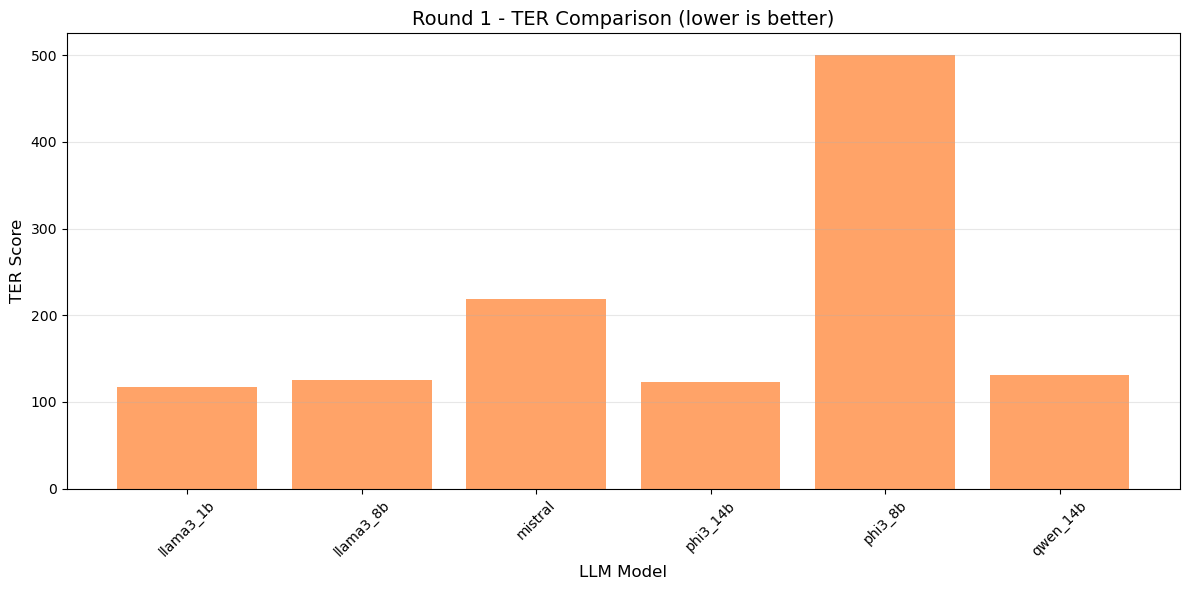

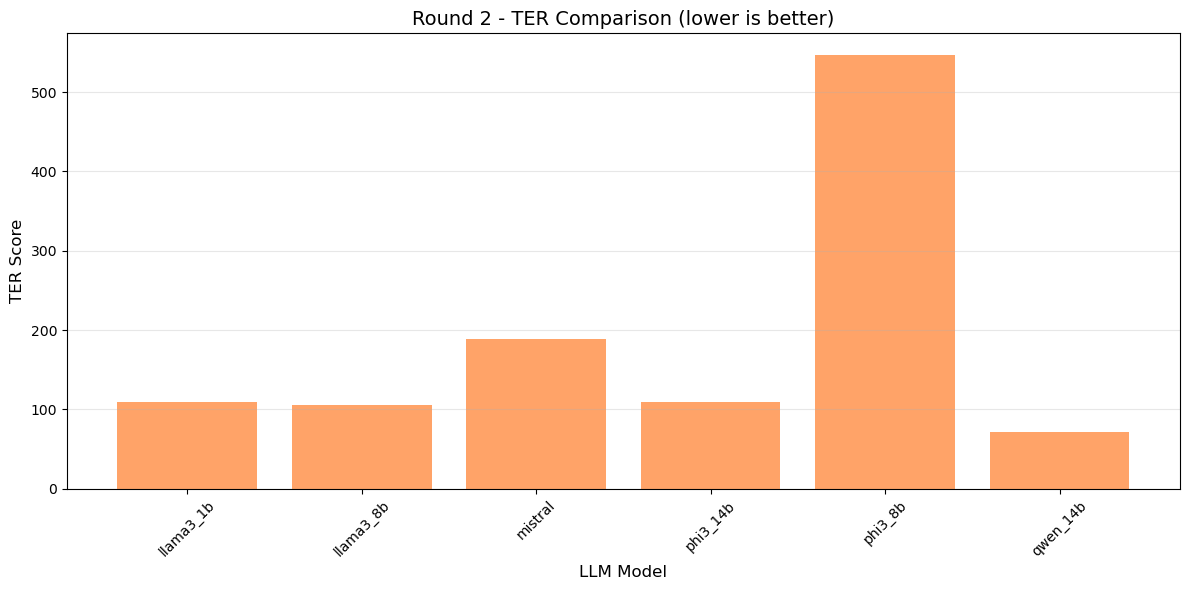

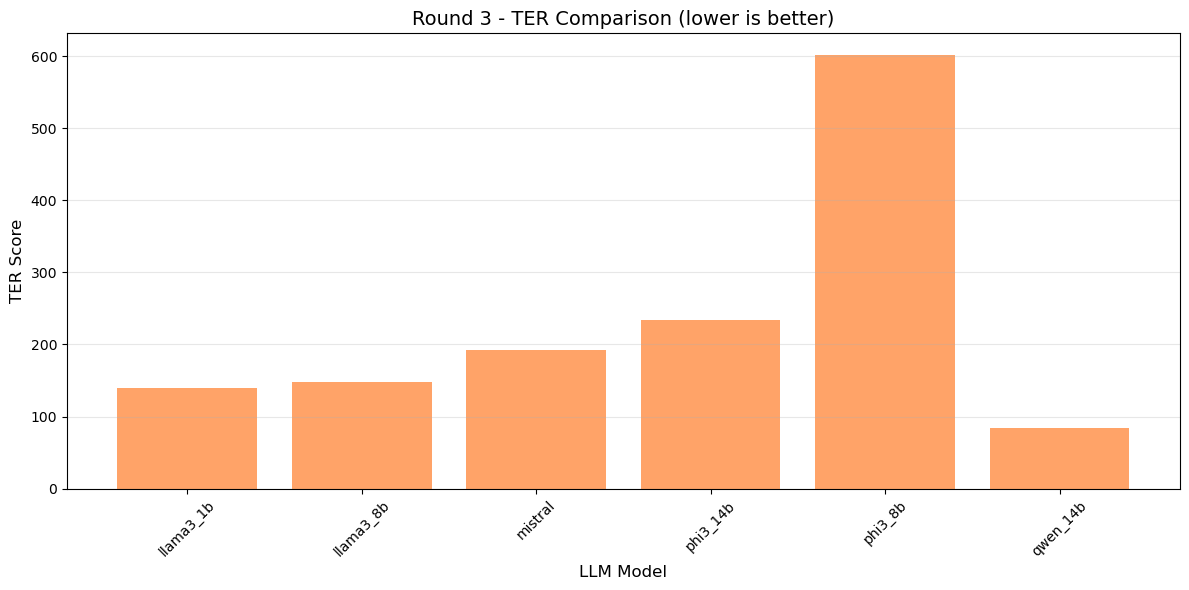

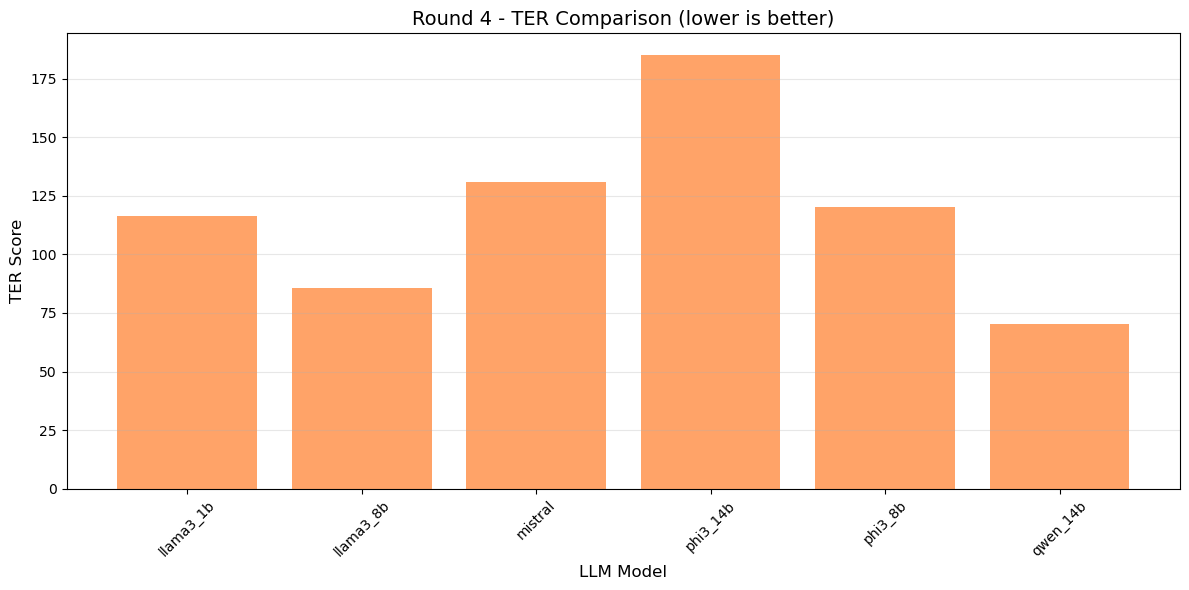

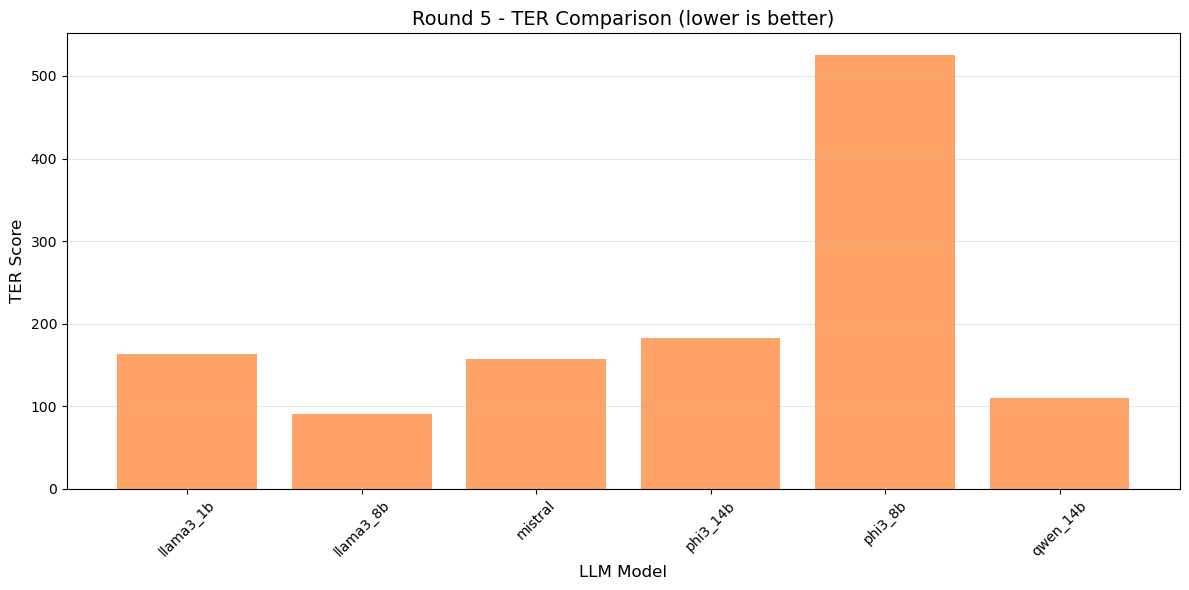

In [10]:
def create_ter_comparison_chart(df, round_num):
    """Create a separate chart for TER (higher values, different scale)."""
    round_data = df[df['round'] == round_num]
    
    if round_data.empty:
        return
    
    llms = round_data['llm'].tolist()
    ter_values = round_data['avg_ter_test'].tolist()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(llms, ter_values, color='#FF8C42', alpha=0.8)
    
    ax.set_xlabel('LLM Model', fontsize=12)
    ax.set_ylabel('TER Score', fontsize=12)
    ax.set_title(f'Round {round_num} - TER Comparison (lower is better)', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    chart_path = CHARTS_DIR / f'round_{round_num}_ter_comparison.png'
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    plt.show()

# Generate TER charts
for round_num in rounds:
    create_ter_comparison_chart(summary_df, round_num)

## 4. Overall Summary Across All Rounds

In [11]:
# Average across all rounds per LLM
overall_summary = summary_df.groupby('llm').agg({
    'avg_bleu_score': 'mean',
    'avg_chrF_score': 'mean',
    'avg_ter_test': 'mean',
    'avg_bert_score_f1': 'mean'
}).reset_index()

overall_summary.columns = ['LLM', 'BLEU', 'chrF', 'TER', 'BERT_F1']
overall_summary

,LLM,BLEU,chrF,TER,BERT_F1
0,llama3_1b,4.531514,11.561599,129.051315,0.800563
1,llama3_8b,18.148554,38.914569,111.025585,0.860455
2,mistral,18.951809,42.257270,177.304999,0.845367
3,phi3_14b,20.095544,41.607295,166.968907,0.852385
4,phi3_8b,11.270876,33.865447,458.803562,0.844046
5,qwen_14b,29.297235,50.252861,93.053211,0.872694


In [12]:
# Save overall summary
overall_csv_path = CHARTS_DIR / 'overall_llm_comparison.csv'
overall_summary.to_csv(overall_csv_path, index=False)
print(f"Saved overall summary to {overall_csv_path}")

Saved overall summary to aggregated_metrics/comparison_charts/overall_llm_comparison.csv


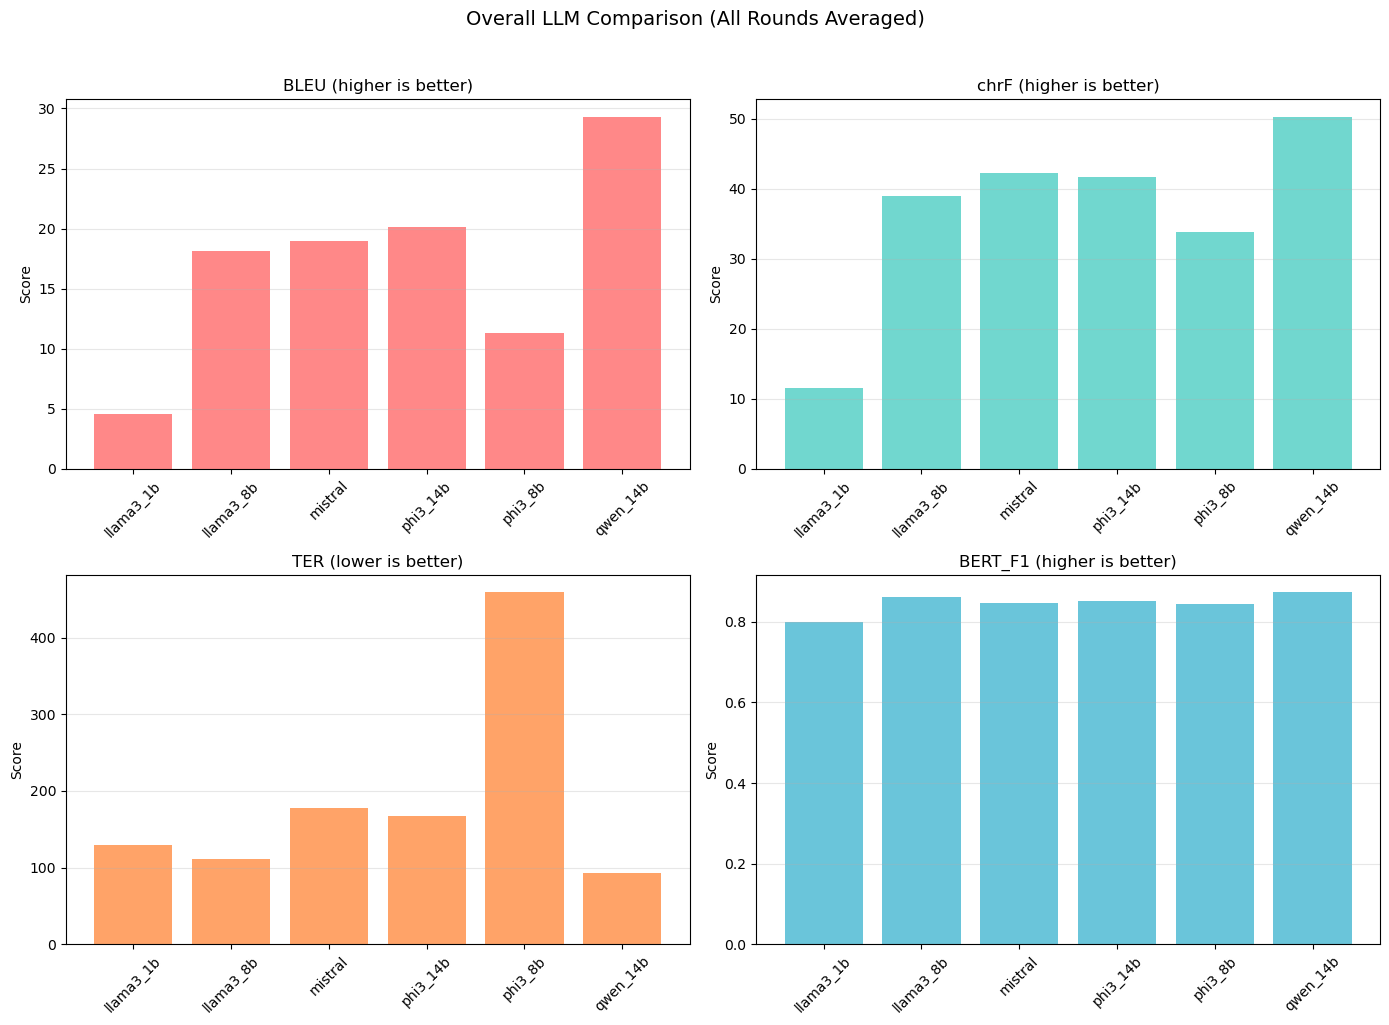

Saved overall chart to aggregated_metrics/comparison_charts/overall_comparison.png


In [13]:
# Create overall comparison chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_info = [
    ('BLEU', '#FF6B6B', 'higher is better'),
    ('chrF', '#4ECDC4', 'higher is better'),
    ('TER', '#FF8C42', 'lower is better'),
    ('BERT_F1', '#45B7D1', 'higher is better')
]

for ax, (metric, color, note) in zip(axes.flatten(), metrics_info):
    values = overall_summary[metric].tolist()
    llms = overall_summary['LLM'].tolist()
    
    bars = ax.bar(llms, values, color=color, alpha=0.8)
    ax.set_title(f'{metric} ({note})', fontsize=12)
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Overall LLM Comparison (All Rounds Averaged)', fontsize=14, y=1.02)
plt.tight_layout()

chart_path = CHARTS_DIR / 'overall_comparison.png'
plt.savefig(chart_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved overall chart to {chart_path}")

## 5. Export Per-Round Summary JSON

In [14]:
# Create per-round summary JSON files
for round_num in rounds:
    round_data = summary_df[summary_df['round'] == round_num]
    
    round_summary = []
    for _, row in round_data.iterrows():
        round_summary.append({
            'llm': row['llm'],
            'round': int(row['round']),
            'avg_bleu_score': row['avg_bleu_score'],
            'avg_chrF_score': row['avg_chrF_score'],
            'avg_ter_test': row['avg_ter_test'],
            'avg_bert_score_f1': row['avg_bert_score_f1'],
            'total_samples': int(row['sample_count'])
        })
    
    output_file = CHARTS_DIR / f'round_{round_num}_all_llms.json'
    with open(output_file, 'w') as f:
        json.dump(round_summary, f, indent=2)
    
    print(f"Saved round {round_num} summary to {output_file}")

Saved round 1 summary to aggregated_metrics/comparison_charts/round_1_all_llms.json
Saved round 2 summary to aggregated_metrics/comparison_charts/round_2_all_llms.json
Saved round 3 summary to aggregated_metrics/comparison_charts/round_3_all_llms.json
Saved round 4 summary to aggregated_metrics/comparison_charts/round_4_all_llms.json
Saved round 5 summary to aggregated_metrics/comparison_charts/round_5_all_llms.json


In [15]:
print("\n=== Processing Complete ===")
print(f"\nOutput files saved to: {OUTPUT_DIR.absolute()}")
print(f"\nGenerated files:")
for f in OUTPUT_DIR.rglob('*'):
    if f.is_file():
        print(f"  - {f.relative_to(OUTPUT_DIR)}")


=== Processing Complete ===

Output files saved to: /home/rei/Documents/Code Projects/Constructed-Language-Experiments/aggregated_metrics

Generated files:
  - comparison_charts/overall_comparison.png
  - comparison_charts/round_5_ter_comparison.png
  - comparison_charts/round_2_all_llms.json
  - comparison_charts/round_4_ter_comparison.png
  - comparison_charts/round_3_comparison.png
  - comparison_charts/round_5_all_llms.json
  - comparison_charts/round_1_ter_comparison.png
  - comparison_charts/round_2_comparison.png
  - comparison_charts/round_1_all_llms.json
  - comparison_charts/overall_llm_comparison.csv
  - comparison_charts/all_models_summary.csv
  - comparison_charts/round_4_all_llms.json
  - comparison_charts/round_5_comparison.png
  - comparison_charts/round_3_ter_comparison.png
  - comparison_charts/round_3_all_llms.json
  - comparison_charts/round_2_ter_comparison.png
  - comparison_charts/round_4_comparison.png
  - comparison_charts/round_1_comparison.png
  - llama3_8b/